# Modelling for Total

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

Load in cleaned up data and creating TOTAL variable

In [2]:
df = pd.read_csv('games_4_7.csv')
df['TOTAL'] = df['PTS_home'] + df['PTS_away']
df.head()

,Unnamed: 0,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_NAME_home,PTS_home,FG_PCT_home,...,FG3A_away,FG3M_away,WSE_home,WSE_away,WSE_DIFF,SEASON_PACE_home,SEASON_PACE_away,SEASON_ORB%_home,SEASON_ORB%_away,TOTAL
0,0,12/19/20,12000047,Final,1610612753,1610612766,2020,Orlando Magic,120.0,0.433,...,41,18,2.933,3.069,-0.136,98.6,95.8,22.3,23.9,237.0
1,1,12/19/20,12000048,Final,1610612764,1610612765,2020,Washington Wizards,99.0,0.427,...,46,15,2.364,2.429,-0.065,102.7,97.6,22.2,22.6,195.0
2,2,12/19/20,12000049,Final,1610612763,1610612737,2020,Memphis Grizzlies,116.0,0.400,...,37,11,2.732,2.572,0.160,102.8,103.0,23.0,21.6,233.0
3,3,12/18/20,12000039,Final,1610612754,1610612755,2020,Indiana Pacers,107.0,0.371,...,31,11,2.220,2.760,-0.540,98.9,99.0,20.0,23.9,220.0
4,4,12/18/20,12000040,Final,1610612761,1610612748,2020,Toronto Raptors,105.0,0.380,...,37,19,2.565,3.351,-0.786,100.9,98.3,21.3,20.3,222.0


In [3]:
#drop variables that are unnecessary or correlated with others
to_drop = ['Unnamed: 0', 'GAME_ID', 'GAME_STATUS_TEXT', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'PTS_home', 'PTS_away', 'HOME_TEAM_WINS', 'TOTAL', 'SEASON', 'FGA_home', 'FGM_home', 'FG3A_home', 'FG3M_home', 'FGA_away', 'FGM_away', 'FG3A_away', 'FG3M_away', 'WSE_DIFF']

In [4]:
X = df.drop(to_drop, 1)
y = df['TOTAL']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 538)

## Feature Selection

### Random Forest

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

In [7]:
X_train_n = X_train.drop(["TEAM_NAME_home", "TEAM_NAME_away", "GAME_DATE_EST"], 1)

In [8]:
sel = SelectFromModel(RandomForestRegressor(n_estimators = 100))
sel.fit(X_train_n, y_train)

SelectFromModel(estimator=RandomForestRegressor())

In [9]:
selected_feat= X_train_n.columns[(sel.get_support())]
print(selected_feat)

Index(['FG_PCT_home', 'AST_home', 'FG_PCT_away', 'SEASON_PACE_away'], dtype='object')


In [10]:
sel_more = SelectFromModel(RandomForestRegressor(n_estimators = 100), threshold = "median")
sel_more.fit(X_train_n, y_train)
selected_feat_more= X_train_n.columns[(sel_more.get_support())]
print(selected_feat_more)

Index(['FG_PCT_home', 'AST_home', 'FG_PCT_away', 'AST_away', 'REB_away',
       'WSE_home', 'WSE_away', 'SEASON_PACE_home', 'SEASON_PACE_away'],
      dtype='object')


In [11]:
print(X_train_n.columns)

Index(['FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home',
       'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away',
       'OREB_home', 'OREB_away', 'WSE_home', 'WSE_away', 'SEASON_PACE_home',
       'SEASON_PACE_away', 'SEASON_ORB%_home', 'SEASON_ORB%_away'],
      dtype='object')


### LASSO

In [12]:
import numpy as np
from sklearn.linear_model import Lasso, LogisticRegression

In [13]:
sel_lasso = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear', max_iter = 500))
sel_lasso.fit(X_train_n, np.ravel(y_train,order='C'))

SelectFromModel(estimator=LogisticRegression(C=1, max_iter=500, penalty='l1',
                                             solver='liblinear'))

In [14]:
selected_feat = X_train_n.columns[(sel_lasso.get_support())]
print('total features: {}'.format((X_train_n.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print(selected_feat)
print('features with coefficients shrank to zero: {}'.format(
np.sum(sel_lasso.estimator_.coef_ == 0)))

total features: 18
selected features: 14
Index(['FT_PCT_home', 'AST_home', 'REB_home', 'FT_PCT_away', 'AST_away',
       'REB_away', 'OREB_home', 'OREB_away', 'WSE_home', 'WSE_away',
       'SEASON_PACE_home', 'SEASON_PACE_away', 'SEASON_ORB%_home',
       'SEASON_ORB%_away'],
      dtype='object')
features with coefficients shrank to zero: 985


Due to the regularization aspect, we will be going forward with selected features as suggested by the LASSO feature selection.

In [15]:
#X_train_sel = X_train_n[['FT_PCT_home', 'AST_home', 'REB_home', 'FT_PCT_away', 'AST_away',
#       'REB_away', 'OREB_home', 'OREB_away', 'WSE_home', 'WSE_away',
#       'SEASON_PACE_home', 'SEASON_PACE_away', 'SEASON_ORB%_home',
#       'SEASON_ORB%_away']]
X_train_sel = X_train_n[['FT_PCT_home', 'AST_home', 'REB_home', 'FT_PCT_away',
       'AST_away', 'REB_away', 'OREB_home', 'OREB_away', 'WSE_home',
       'WSE_away', 'SEASON_PACE_home', 'SEASON_PACE_away', 'SEASON_ORB%_home',
       'SEASON_ORB%_away']]
X_train_sel.head()

,FT_PCT_home,AST_home,REB_home,FT_PCT_away,AST_away,REB_away,OREB_home,OREB_away,WSE_home,WSE_away,SEASON_PACE_home,SEASON_PACE_away,SEASON_ORB%_home,SEASON_ORB%_away
2040,0.737,23.0,46.0,0.889,31.0,57.0,12,12,2.013,3.015,98.4,95.6,22.2,18.0
5231,0.839,24.0,54.0,0.957,23.0,40.0,13,4,2.709,2.632,97.9,96.6,20.6,23.4
1994,0.905,28.0,43.0,0.895,22.0,37.0,6,10,3.306,3.046,96.5,98.3,23.3,20.6
971,1.000,23.0,54.0,0.789,19.0,38.0,10,8,3.443,2.617,99.1,102.8,26.6,26.0
3092,0.800,20.0,49.0,0.857,21.0,45.0,13,11,2.404,2.943,96.0,96.8,26.6,21.2


In [16]:
#X_test_sel = X_test[['FT_PCT_home', 'AST_home', 'REB_home', 'FT_PCT_away', 'AST_away',
#       'REB_away', 'OREB_home', 'OREB_away', 'WSE_home', 'WSE_away',
#       'SEASON_PACE_home', 'SEASON_PACE_away', 'SEASON_ORB%_home',
#       'SEASON_ORB%_away']]

X_test_sel = X_test[['FT_PCT_home', 'AST_home', 'REB_home', 'FT_PCT_away',
       'AST_away', 'REB_away', 'OREB_home', 'OREB_away', 'WSE_home',
       'WSE_away', 'SEASON_PACE_home', 'SEASON_PACE_away', 'SEASON_ORB%_home',
       'SEASON_ORB%_away']]

## Finding the Best Model

Need to test different regression models to determine which one is 'the best'

### Random Forest Regression

In [17]:
from sklearn import metrics
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [18]:
# create regressor object
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
  
# fit the regressor with x and y data
regressor.fit(X_train_sel, y_train)

#make predictions
y_pred_rf = regressor.predict(X_test_sel)

In [19]:
#evaluate model
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred_rf))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, y_pred_rf))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf)))
mape = np.mean(np.abs((y_test - y_pred_rf) / np.abs(y_test)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Accuracy:', round(100*(1 - mape), 2))
print('R-Squared:', r2_score(y_test, y_pred_rf))

Mean Absolute Error (MAE): 10.830596363636364
Mean Squared Error (MSE): 188.71447265454546
Root Mean Squared Error (RMSE): 13.737338630700833
Mean Absolute Percentage Error (MAPE): 5.11
Accuracy: 94.89
R-Squared: 0.5646132098842525


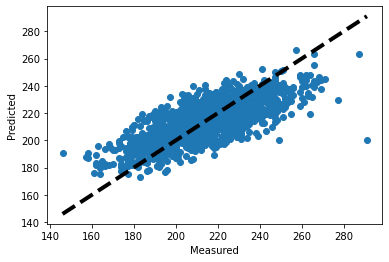

In [20]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred_rf)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

### SVR

In [21]:
from sklearn.svm import SVR

In [22]:
# create svr object
svr_model = SVR()
  
# fit the regressor with x and y data
svr_model.fit(X_train_sel, y_train)

#make predictions
y_pred_svr = svr_model.predict(X_test_sel)

In [23]:
#evaluate model
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred_svr))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, y_pred_svr))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred_svr)))
mape = np.mean(np.abs((y_test - y_pred_svr) / np.abs(y_test)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Accuracy:', round(100*(1 - mape), 2))
print('R-Squared:', r2_score(y_test, y_pred_svr))

Mean Absolute Error (MAE): 13.611773498640623
Mean Squared Error (MSE): 292.7064158058345
Root Mean Squared Error (RMSE): 17.108664933472586
Mean Absolute Percentage Error (MAPE): 6.44
Accuracy: 93.56
R-Squared: 0.324691397372177


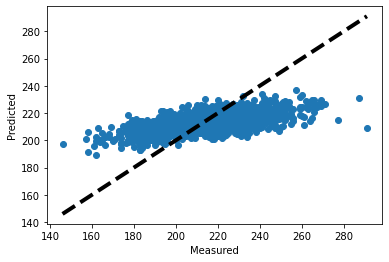

In [24]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred_svr)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

### Decision Tree Regression

In [25]:
from sklearn import tree

In [26]:
# create tree object
dt = tree.DecisionTreeRegressor()
  
# fit the regressor with x and y data
dt.fit(X_train_sel, y_train)

#make predictions
y_pred_dt = dt.predict(X_test_sel)

In [27]:
#evaluate model
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred_dt))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, y_pred_dt))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred_dt)))
mape = np.mean(np.abs((y_test - y_pred_dt) / np.abs(y_test)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Accuracy:', round(100*(1 - mape), 2))
print('R-Squared:', r2_score(y_test, y_pred_dt))

Mean Absolute Error (MAE): 16.663272727272727
Mean Squared Error (MSE): 433.26836363636363
Root Mean Squared Error (RMSE): 20.815099414520308
Mean Absolute Percentage Error (MAPE): 7.83
Accuracy: 92.17
R-Squared: 0.00039822357633467753


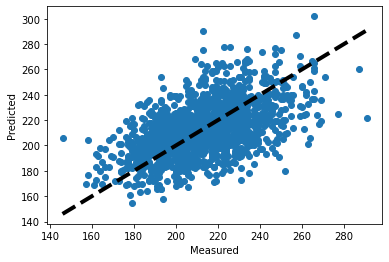

In [28]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred_dt)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

### Linear Regression

In [29]:
from sklearn.linear_model import LinearRegression

In [30]:
# create linear model object
lm = LinearRegression()
  
# fit the regressor with x and y data
lm.fit(X_train_sel, y_train)

#make predictions
y_pred_lm = lm.predict(X_test_sel)

In [31]:
#evaluate model
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred_lm))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, y_pred_lm))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred_lm)))
mape = np.mean(np.abs((y_test - y_pred_lm) / np.abs(y_test)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Accuracy:', round(100*(1 - mape), 2))
print('R-Squared:', r2_score(y_test, y_pred_lm))

Mean Absolute Error (MAE): 10.49011925343016
Mean Squared Error (MSE): 175.6181190659274
Root Mean Squared Error (RMSE): 13.252098666472696
Mean Absolute Percentage Error (MAPE): 4.94
Accuracy: 95.06
R-Squared: 0.5948280591799242


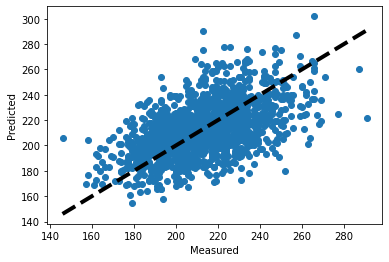

In [32]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred_dt)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

It appears that the linear model is suprisingly the best model. We now need to remodel our 'recent' dataset so we have an set of 'x' to predict the upcoming totals for the games.

## Creating a new 'x'

In order to be able to predict for upcoming games, we will be creating an 'x' based off each team's box score averages for the 2021 season to put in our model to attain our predictions. The data can be found at: https://www.espn.com/nba/stats/team and https://www.espn.com/nba/stats/team/_/view/opponent. The dataset was created with Excel and will be read in below:

In [33]:
# read in prediction.csv
pred = pd.read_csv('Predictions.csv')

#read in new x csv
x_for_pred = pd.read_csv('x_for_pred.csv')

In [34]:
pred.head()

,DATE,Home Team,Away Team,Spread,Total,OREB
0,4/10/2021,Brooklyn Nets,Los Angeles Lakers,NaN,NaN,NaN
1,4/10/2021,Oklahoma City Thunder,Philadelphia 76ers,NaN,NaN,NaN
2,4/10/2021,Utah Jazz,Sacramento Kings,NaN,NaN,NaN
3,4/10/2021,Golden State Warriors,Houston Rockets,NaN,NaN,NaN
4,4/10/2021,Phoenix Suns,Washington Wizards,NaN,NaN,NaN


In [35]:
x_for_pred.head()

,TEAM_home,TEAM_away,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,OREB_home,OREB_away,WSE_home,WSE_away,SEASON_PACE_home,SEASON_PACE_away,SEASON_ORB_home,SEASON_ORB_away
0,Brooklyn Nets,Los Angeles Lakers,0.494,0.800,0.393,26.8,44.3,0.454,0.765,0.350,24.7,41.9,9.0,9.1,2.967,2.723,99.7,98.9,21.6,22.6
1,Oklahoma City Thunder,Philadelphia 76ers,0.445,0.738,0.348,22.6,44.9,0.452,0.768,0.363,23.5,42.0,8.9,9.4,2.672,2.761,100.2,100.6,18.3,24.1
2,Utah Jazz,Sacramento Kings,0.467,0.790,0.390,23.5,48.3,0.488,0.799,0.392,25.4,44.8,10.9,10.5,2.894,2.951,98.8,99.9,25.2,22.8
3,Golden State Warriors,Houston Rockets,0.461,0.778,0.368,27.3,42.6,0.468,0.780,0.373,24.6,48.1,8.0,10.1,2.804,2.835,102.6,101.3,17.2,19.1
4,Phoenix Suns,Washington Wizards,0.489,0.832,0.376,27.0,43.5,0.472,0.777,0.380,24.1,46.8,8.5,10.3,2.938,2.861,97.1,104.3,20.2,20.1


## Make predictions with our best model!

In [36]:
season_avg_21 = x_for_pred[['FT_PCT_home', 'AST_home', 'REB_home', 'FT_PCT_away',
       'AST_away', 'REB_away', 'OREB_home', 'OREB_away', 'WSE_home',
       'WSE_away', 'SEASON_PACE_home', 'SEASON_PACE_away', 'SEASON_ORB_home',
       'SEASON_ORB_away']]

In [37]:
y_pred_21 = lm.predict(season_avg_21)
y_pred_21

array([226.27624614, 218.51832189, 232.81564923, 231.73461412,
       233.32652646, 219.83232832, 224.06306237, 224.95049821,
       220.6308141 , 223.74714277, 222.38530068, 220.75665768,
       232.867026  , 223.03113779, 226.2505877 , 218.1737578 ,
       215.43442726, 221.52045691, 223.74452264, 218.18350668,
       227.71668208, 232.05038989, 234.68143668, 225.20735471,
       229.8900314 , 220.45363034, 220.33839434, 223.59914788,
       228.40749203, 223.06903723, 218.56968379, 226.70140163,
       225.55174294, 224.69606828, 214.92660934, 229.92981127,
       227.82916678, 217.43923253, 223.25493812, 224.07505332,
       223.703953  , 224.55457221, 232.31756162, 228.27912426,
       222.31927585, 220.59471319, 231.46073902, 231.1824724 ,
       221.51491246, 220.62541854, 229.98340157, 232.20300487,
       224.25639621, 231.03658527, 216.79014794, 221.42295677,
       222.78849941, 210.35767796, 217.9877541 , 226.16732925,
       228.65014866, 227.3134575 , 233.62119639, 227.24

In [38]:
pred['Total'] = y_pred_21
pred.head()

,DATE,Home Team,Away Team,Spread,Total,OREB
0,4/10/2021,Brooklyn Nets,Los Angeles Lakers,NaN,226.276246,NaN
1,4/10/2021,Oklahoma City Thunder,Philadelphia 76ers,NaN,218.518322,NaN
2,4/10/2021,Utah Jazz,Sacramento Kings,NaN,232.815649,NaN
3,4/10/2021,Golden State Warriors,Houston Rockets,NaN,231.734614,NaN
4,4/10/2021,Phoenix Suns,Washington Wizards,NaN,233.326526,NaN


Save the new predictions csv with our predictions for Total

In [39]:
pred.to_csv('total_predictions.csv')